# Mouse Olfactory Bulb Analysis

**Date** : 2021-07-14<br>
**Author** : Alma Andersson<br>
**Description** : <br>
<br>
This notebook outlines the exact workflow to generate the results presented in Figure 2B, where 12 sections of the mouse olfactory bulb (MOB) are mapped to a given reference.

Load necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scanpy as sc

import os.path as osp
import os
from PIL import Image

import anndata as ad
import pandas as pd
import sys

import eggplant as eg



Set plotting parameters

In [2]:
from matplotlib import rcParams
rcParams["figure.facecolor"] = "None"
rcParams["axes.facecolor"] = "None"

## Load and process Reference Information

Define paths to data and reference images

In [3]:
DATA_DIR = "../../data/science-mob/charted/"
REF_IMG_PTH = "../../rsc/ref/science-mob/science-mob-wo-reds.png"
REF_LMK_PTH = "../../rsc/ref/science-mob/science-mob_landmarks.tsv"

Load reference image

In [4]:
ref_img = Image.open(REF_IMG_PTH)
ref_lmk = pd.read_csv(REF_LMK_PTH,sep="\t",header = 0,index_col =0)

Inspect the reference image to make sure we loaded the correct image. Also plot the landmark coordinates to ensure that these match the reference.

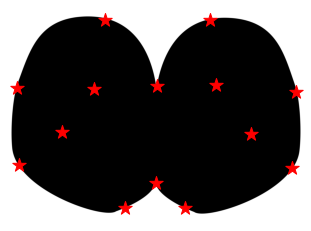

In [5]:
plt.imshow(ref_img)
plt.scatter(ref_lmk.values[:,0],
            ref_lmk.values[:,1],
            marker = "*",
            c = "red",
            s = 200,
           )
plt.axis("off")
plt.show()

Everything seems fine with the reference and landmark coordinates. We therefore proceed to convert the image to a grid with associated meta data (which region each grid point belongs to). The number of points in the grid will be close to `n_approx_points`, the more points, the higher the resolution. The argument `n_regions`specifies how many regions we have defined, by different colors, in our reference.

In [6]:
grid_crd,mta = eg.pp.reference_to_grid(ref_img,
                                    n_approx_points=1000,
                                    n_regions=1,
                                   )

We also plot the newly created grid to make sure it looks as we'd expect it to. We can again overlay the landmarks.

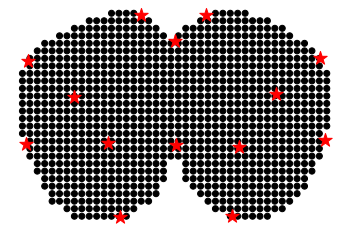

In [7]:
plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            c= mta,
            cmap = plt.cm.binary_r,
           )

plt.scatter(ref_lmk.values[:,0],
            ref_lmk.values[:,1],
            marker = "*",
            c = "red",
            s = 200,
           )

plt.axis("equal")
plt.axis("off")
plt.show()

From the grid and landmarks we may now create a `Reference` object, which will be used in the transfer process.

In [8]:
ref = eg.m.Reference(grid_crd,
                     landmarks = ref_lmk.values,
                     meta = dict(region = mta),
                    )

## Load and process Expression Data

First, we load the anndata files from the designated data directory `DATA_DIR`

In [9]:
adatas = {p.split(".")[0]:ad.read_h5ad(osp.join(DATA_DIR,p)) for p in os.listdir(DATA_DIR)}
adatas = {f"Rep{k}_MOB" : adatas[f"Rep{k}_MOB"] for k \
          in sorted([ int(a.lstrip("Rep_").rstrip("_MOB")) for a in adatas.keys()])}

Next, we execute some standard pre-processing steps such as filter, normalize, log-transform, and scaling. However, we also match the scales between the observed data and the reference (`match_scales`), after which we compute the distance for every spot to each landmark (`get_landmark_distance`). We supply the aforementioned function with the reference object, to conduct TPS warping and thus account for non-homogenous disruptions in the morphology.

In [10]:
for adata in adatas.values():
    # standard normalization steps
    sc.pp.filter_genes(adata,
                       min_cells = 0.1)
    
    sc.pp.normalize_total(adata,1e4,
                          exclude_highly_expressed = False)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    
    #--- eggplant specific pre-processing---
    # match scales
    eg.pp.match_scales(adata,ref)
    # perform TPS warping and calculate landmark distances
    eg.pp.get_landmark_distance(adata,
                                reference=ref)    

    eg.pp.spatial_smoothing(adata)


As is proper, we then inspect our processed data to see that everything looks as expected.

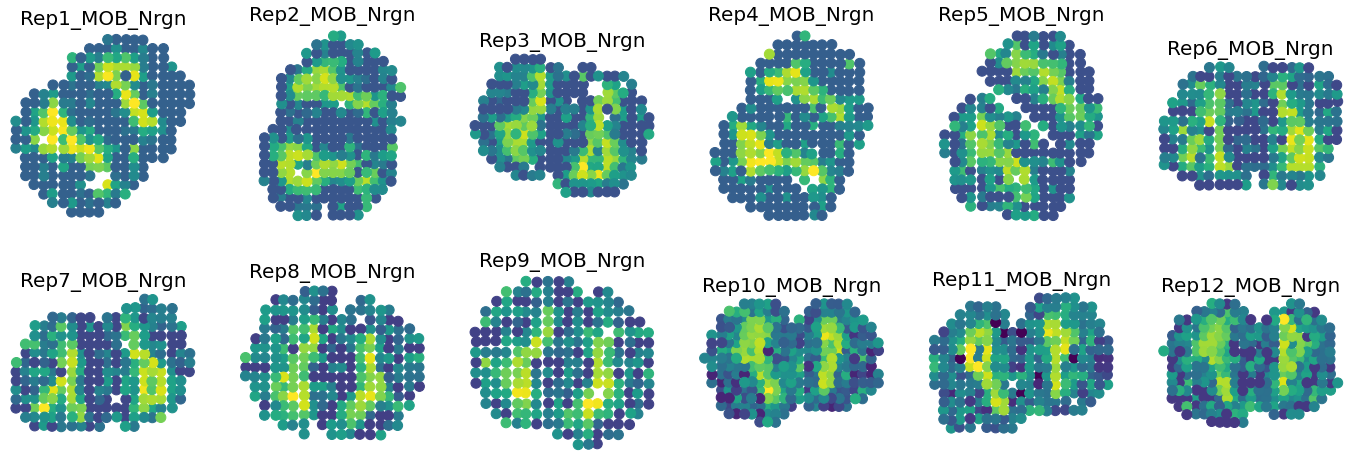

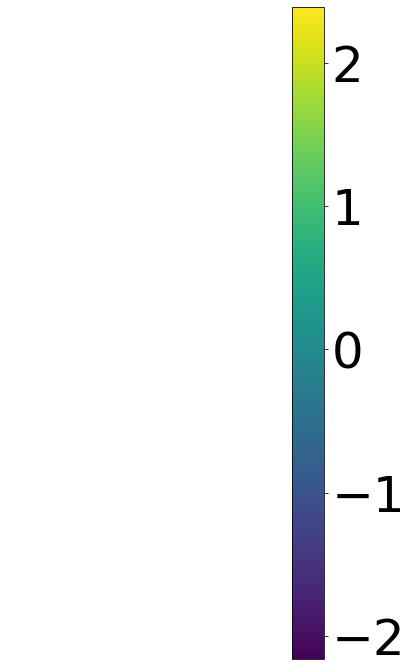

In [11]:
# Output used for Figure 2B
eg.pl.visualize_observed(adatas,
                         features = "Nrgn",
                         n_rows = 2,
                         include_title = True,
                         fontsize = 20,
                         marker_size =100,
                         share_colorscale = True,
                         separate_colorbar = True,
                         side_size = 4,
                         show_landmarks = False,
                         quantile_scaling = True,
                        )

In [12]:
adatas["Rep1_MOB"].layers

Layers with keys: smoothed

We now transfer our data to the reference using the `transfer_to_reference` function. Here we use the gene _Nrgn_ as our target of interest, but this may be exchanged for any of the other two genes presented in the supplementary (or any gene of the users liking). We use $1000$ epochs and `cuda` acceleration, if possible. We also set `verbose=True` in order to be able to follow the progress.

In [131]:
ref.clean()

In [132]:
losses = eg.fun.transfer_to_reference(adatas,
                                      reference=ref,
                                      layer = "smoothed",
                                      features = ["Nrgn","Apoe","Omp"],
                                      n_epochs=1000,
                                      device ="cuda",
                                      verbose=True,
                                     )

[Processing] ::  Model : Rep1_MOB | Feature : Nrgn | Transfer : 1/36


100%|██████████| 1000/1000 [00:05<00:00, 197.00it/s]


[Processing] ::  Model : Rep1_MOB | Feature : Apoe | Transfer : 2/36


/home/alma/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 1000/1000 [00:05<00:00, 176.53it/s]


[Processing] ::  Model : Rep1_MOB | Feature : Omp | Transfer : 3/36


100%|██████████| 1000/1000 [00:05<00:00, 180.59it/s]


[Processing] ::  Model : Rep2_MOB | Feature : Nrgn | Transfer : 4/36


100%|██████████| 1000/1000 [00:05<00:00, 171.19it/s]


[Processing] ::  Model : Rep2_MOB | Feature : Apoe | Transfer : 5/36


100%|██████████| 1000/1000 [00:06<00:00, 159.60it/s]


[Processing] ::  Model : Rep2_MOB | Feature : Omp | Transfer : 6/36


100%|██████████| 1000/1000 [00:05<00:00, 182.65it/s]


[Processing] ::  Model : Rep3_MOB | Feature : Nrgn | Transfer : 7/36


100%|██████████| 1000/1000 [00:05<00:00, 185.88it/s]


[Processing] ::  Model : Rep3_MOB | Feature : Apoe | Transfer : 8/36


100%|██████████| 1000/1000 [00:06<00:00, 166.21it/s]


[Processing] ::  Model : Rep3_MOB | Feature : Omp | Transfer : 9/36


100%|██████████| 1000/1000 [00:05<00:00, 187.07it/s]


[Processing] ::  Model : Rep4_MOB | Feature : Nrgn | Transfer : 10/36


100%|██████████| 1000/1000 [00:05<00:00, 194.62it/s]


[Processing] ::  Model : Rep4_MOB | Feature : Apoe | Transfer : 11/36


100%|██████████| 1000/1000 [00:05<00:00, 194.98it/s]


[Processing] ::  Model : Rep4_MOB | Feature : Omp | Transfer : 12/36


100%|██████████| 1000/1000 [00:05<00:00, 185.84it/s]


[Processing] ::  Model : Rep5_MOB | Feature : Nrgn | Transfer : 13/36


100%|██████████| 1000/1000 [00:05<00:00, 186.52it/s]


[Processing] ::  Model : Rep5_MOB | Feature : Apoe | Transfer : 14/36


100%|██████████| 1000/1000 [00:05<00:00, 185.92it/s]


[Processing] ::  Model : Rep5_MOB | Feature : Omp | Transfer : 15/36


100%|██████████| 1000/1000 [00:05<00:00, 188.15it/s]


[Processing] ::  Model : Rep6_MOB | Feature : Nrgn | Transfer : 16/36


100%|██████████| 1000/1000 [00:04<00:00, 203.12it/s]


[Processing] ::  Model : Rep6_MOB | Feature : Apoe | Transfer : 17/36


100%|██████████| 1000/1000 [00:04<00:00, 202.24it/s]


[Processing] ::  Model : Rep6_MOB | Feature : Omp | Transfer : 18/36


100%|██████████| 1000/1000 [00:04<00:00, 210.56it/s]


[Processing] ::  Model : Rep7_MOB | Feature : Nrgn | Transfer : 19/36


100%|██████████| 1000/1000 [00:04<00:00, 212.78it/s]


[Processing] ::  Model : Rep7_MOB | Feature : Apoe | Transfer : 20/36


100%|██████████| 1000/1000 [00:04<00:00, 211.64it/s]


[Processing] ::  Model : Rep7_MOB | Feature : Omp | Transfer : 21/36


100%|██████████| 1000/1000 [00:04<00:00, 201.44it/s]


[Processing] ::  Model : Rep8_MOB | Feature : Nrgn | Transfer : 22/36


100%|██████████| 1000/1000 [00:04<00:00, 214.93it/s]


[Processing] ::  Model : Rep8_MOB | Feature : Apoe | Transfer : 23/36


100%|██████████| 1000/1000 [00:04<00:00, 201.99it/s]


[Processing] ::  Model : Rep8_MOB | Feature : Omp | Transfer : 24/36


100%|██████████| 1000/1000 [00:04<00:00, 208.18it/s]


[Processing] ::  Model : Rep9_MOB | Feature : Nrgn | Transfer : 25/36


100%|██████████| 1000/1000 [00:05<00:00, 195.17it/s]


[Processing] ::  Model : Rep9_MOB | Feature : Apoe | Transfer : 26/36


100%|██████████| 1000/1000 [00:04<00:00, 211.45it/s]


[Processing] ::  Model : Rep9_MOB | Feature : Omp | Transfer : 27/36


100%|██████████| 1000/1000 [00:04<00:00, 202.96it/s]


[Processing] ::  Model : Rep10_MOB | Feature : Nrgn | Transfer : 28/36


100%|██████████| 1000/1000 [00:06<00:00, 157.04it/s]


[Processing] ::  Model : Rep10_MOB | Feature : Apoe | Transfer : 29/36


100%|██████████| 1000/1000 [00:06<00:00, 143.22it/s]


[Processing] ::  Model : Rep10_MOB | Feature : Omp | Transfer : 30/36


100%|██████████| 1000/1000 [00:06<00:00, 163.27it/s]


[Processing] ::  Model : Rep11_MOB | Feature : Nrgn | Transfer : 31/36


100%|██████████| 1000/1000 [00:05<00:00, 187.93it/s]


[Processing] ::  Model : Rep11_MOB | Feature : Apoe | Transfer : 32/36


100%|██████████| 1000/1000 [00:05<00:00, 187.80it/s]


[Processing] ::  Model : Rep11_MOB | Feature : Omp | Transfer : 33/36


100%|██████████| 1000/1000 [00:05<00:00, 185.16it/s]


[Processing] ::  Model : Rep12_MOB | Feature : Nrgn | Transfer : 34/36


100%|██████████| 1000/1000 [00:05<00:00, 170.92it/s]


[Processing] ::  Model : Rep12_MOB | Feature : Apoe | Transfer : 35/36


100%|██████████| 1000/1000 [00:05<00:00, 176.51it/s]


[Processing] ::  Model : Rep12_MOB | Feature : Omp | Transfer : 36/36


100%|██████████| 1000/1000 [00:05<00:00, 175.89it/s]


Having fitted our models, we now inspect their respective losses - to control for any unexpected abberrations - and find that all our curves look as we would expect them to as well as seeming to have converged.

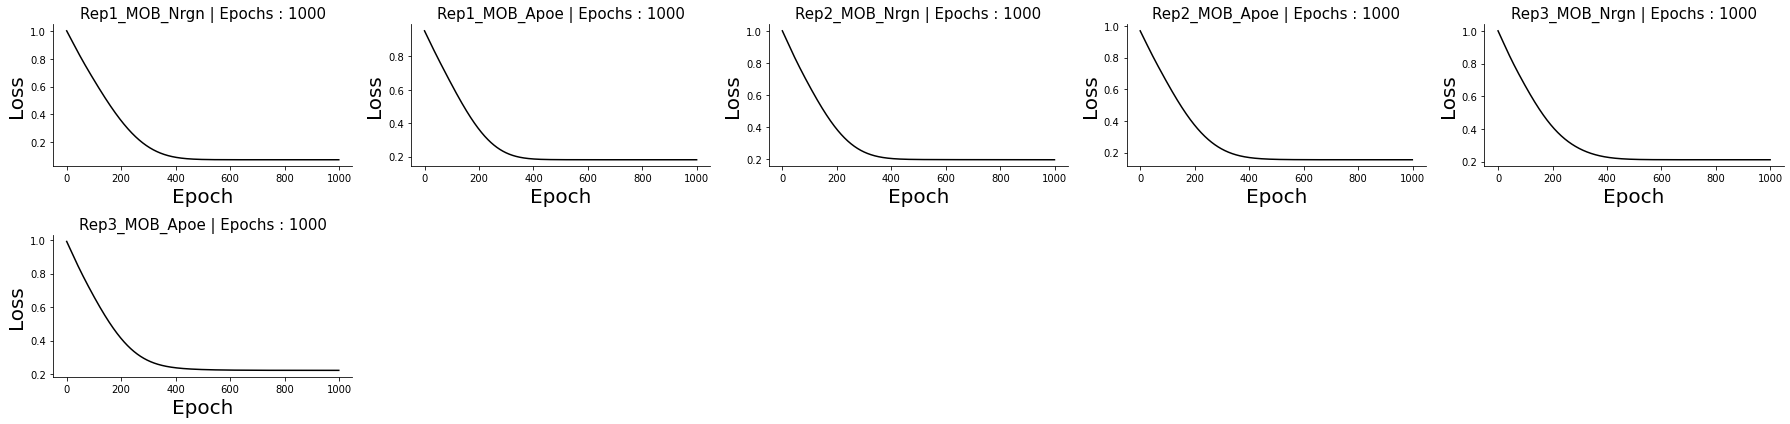

In [15]:
eg.pl.model_diagnostics(losses = losses)

Finally, we visualize our results

In [150]:
ref.adata.var

,model,feature
Rep1_MOB_Nrgn,Rep1_MOB,Nrgn
Rep1_MOB_Apoe,Rep1_MOB,Apoe
Rep1_MOB_Omp,Rep1_MOB,Omp
Rep2_MOB_Nrgn,Rep2_MOB,Nrgn
Rep2_MOB_Apoe,Rep2_MOB,Apoe
Rep2_MOB_Omp,Rep2_MOB,Omp
Rep3_MOB_Nrgn,Rep3_MOB,Nrgn
Rep3_MOB_Apoe,Rep3_MOB,Apoe
Rep3_MOB_Omp,Rep3_MOB,Omp
Rep4_MOB_Nrgn,Rep4_MOB,Nrgn


In [140]:
res = eg.de.dgea(ref.adata,
                 group_col="feature",n_std=2,
                )

In [148]:
from typing import Dict
import numpy as np
    

def visualize_dge(ref: "m.GPModel",
                  dge_res: Dict[str,np.ndarray],
                  cmap: str = "RdBu",
                  n_cols: int = 4,
                  marker_size: float = 10,
                  side_size = 8,
                  )->None:
    
    n_comps = len(dge_res)
    if cmap in plt.colormaps():
        cmap = eval("plt.cm." + cmap)
    else:
        cmap = plt.cm.RdBu

    
    n_rows,n_cols = eg.ut.get_figure_dims(n_total=n_comps,
                                          n_cols=n_cols)
    
    crd = ref.adata.obsm["spatial"]
    names = list(dge_res.keys())
    
    figsize = (side_size * n_cols,side_size * n_rows)
    fig,ax = plt.subplots(n_rows,n_cols, figsize = figsize)
    

    ax = ax.flatten()    
    
    
    for k,(comp,vals) in enumerate(dge_res.items()):
        is_sig = vals["sig"]
        
        ax[k].scatter(crd[~is_sig,0],
                      crd[~is_sig,1],
                      c = "lightgray",
                      s = marker_size,
                     )
        
        _sc = ax[k].scatter(crd[is_sig,0],
                      crd[is_sig,1],
                      c = vals["diff"][is_sig],
                      cmap = cmap,
                      s = marker_size,
                     )
        

        pos_name,neg_name = comp.split("_") 
        title = r"$\Delta($" + pos_name + "," + neg_name + ")"
        ax[k].set_title(title,fontsize = 20)

        
        ax[k].set_aspect("equal")
        cbar = fig.colorbar(_sc,ax = ax[k])
        cbar.ax.tick_params(labelsize=20)
        
        o_lbl = cbar.ax.get_yticks()
        n_lbl = [str(o_lbl[0]) + f" ({neg_name})"] +\
        [f"{x:0.2f}" for x in o_lbl[1:-1]] +\
        [str(o_lbl[-1]) + f" ({pos_name})"]
        cbar.ax.set_yticklabels(n_lbl)
        
    for axx in ax: axx.axis("off")
        
    return fig,ax,cbar
        
        
    
    
    
    
    

In [154]:
wdata = ad.read_h5ad("/home/alma/w-projects/ccf/data/developmental-heart/w_10/anndata-alt/V10F24-105_A1.h5ad")
wdata.uns["spatial"]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


{'V10F24-105_A1': {'images': {'hires': array([[[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
   
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
   
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
   
          ...,
   
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
   
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,
           [1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.]],
   
          [[1., 1., 1.],
           [1., 1., 1.],
           [1., 1., 1.],
           ...,

/home/alma/.local/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator


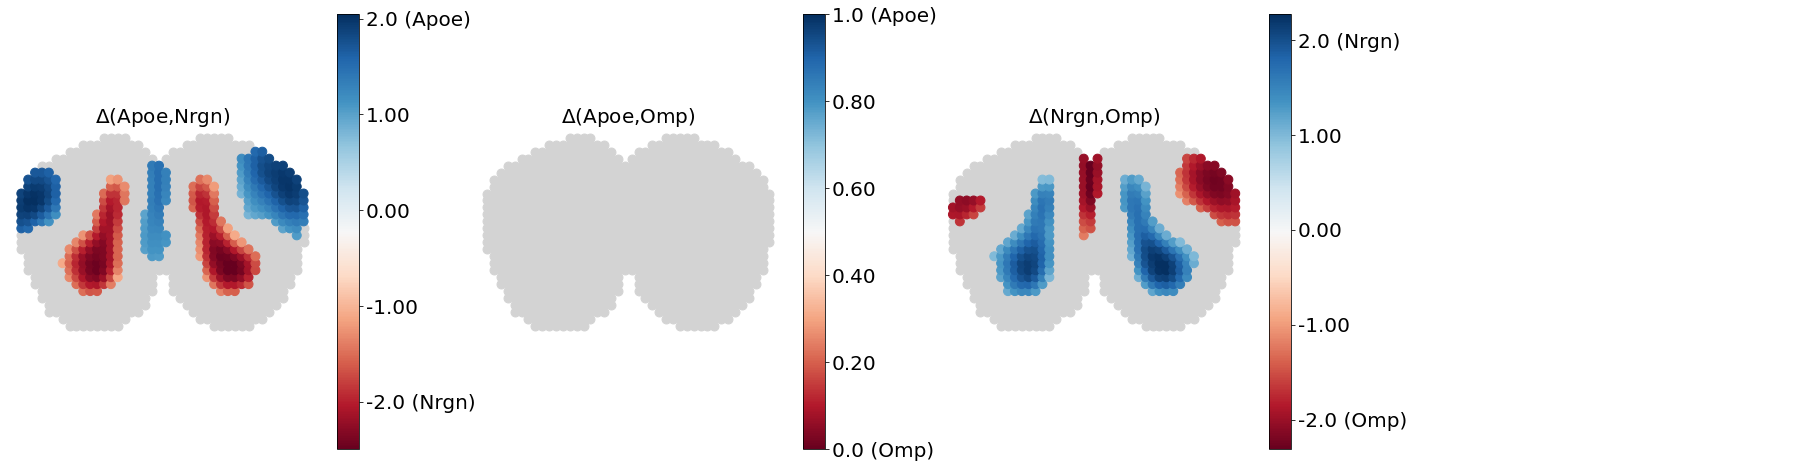

In [149]:
fig,ax,cbar = visualize_dge(ref,res,marker_size = 80)

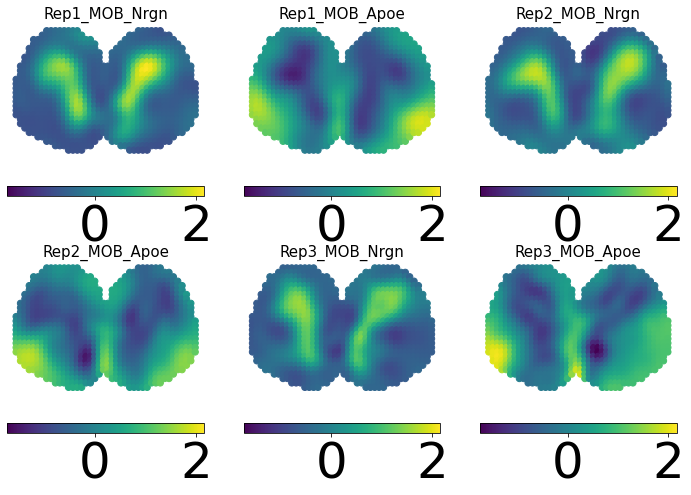

In [28]:
# Output used for Figure 2B
eg.pl.visualize_transfer(ref,
                         n_rows = 2,
                         include_title = True,
                         fontsize = 15,
                         marker_size =40,
                         share_colorscale = True,
                         separate_colorbar = False,
                         side_size = 4,
                         show_landmarks = False,
                         flip_y = True,
                         quantile_scaling = False,
                        )

We can also use look at the average representation

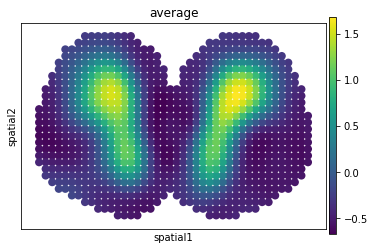

In [16]:
ref.plot("average",spot_size=0.03,cmap = plt.cm.viridis,ncols = 6)